First Name: **Khushbu**

Last Name: **Saradva**

Group: mAIDA22, Data Science, 2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

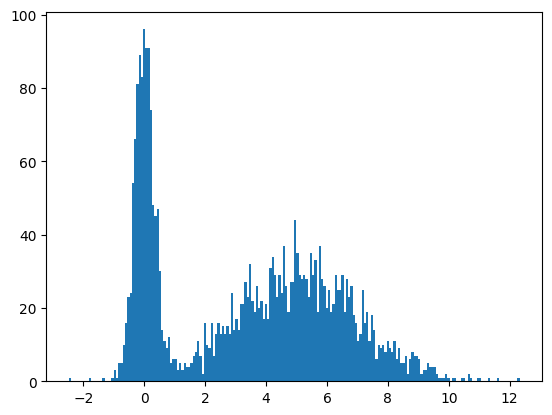

In [2]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

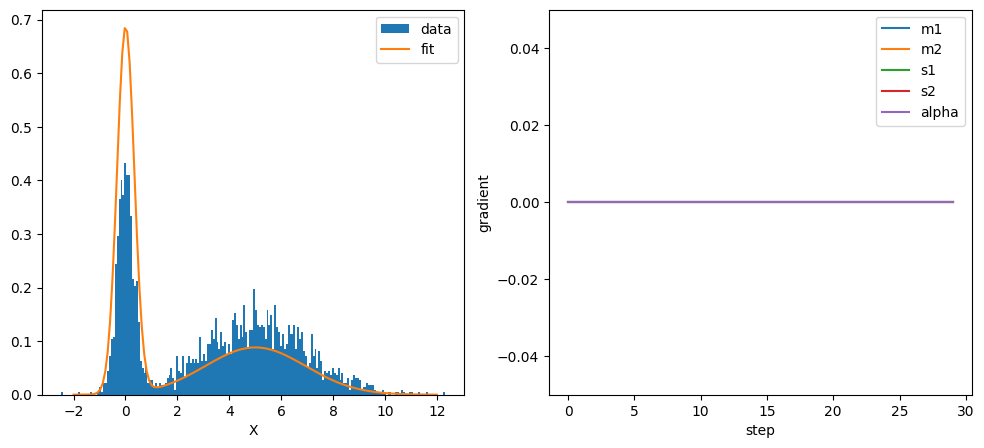

In [3]:
from IPython.display import clear_output


# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
    return 1 / (sigma * torch.sqrt(torch.tensor(2.0 * np.pi))) * torch.exp(-(x - mu)**2 / (2 * sigma**2))


# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
    return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1 = torch.tensor([1.0], requires_grad=True)
m2 = torch.tensor([4.0], requires_grad=True)
s1 = torch.tensor([1.0], requires_grad=True)
s2 = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
    # Ensure the sigmas are positive
    s1.data = torch.max(s1, torch.tensor(1e-5))
    s2.data = torch.max(s2, torch.tensor(1e-5))

    # Ensure alpha is in (0, 1) interval
    alpha.data = torch.sigmoid(alpha)

variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
    return mixture(x,
                   lambda t: gaussian(t, m1, s1),
                   lambda t: gaussian(t, m2, s2),
                   alpha)

# Log likelihood
def loglike(x):
    return torch.sum(torch.log(model_pdf(x)))

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
    # Forward pass:
    l = loglike(torch.tensor(X))

    # Backprop
    l.backward()

    # Gradient ascent step
    with torch.no_grad():
        for var in variables:
            var += learning_rate * var.grad
            var.grad.zero_()

    # Apply constraints
    apply_constraints()

    # Store gradient values
    grad_history.append([var.grad.item() for var in variables])

    # Plotting
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(X, bins=200, density=True, label='data')
    x_grid = np.linspace(-2, 12, 150)
    plt.plot(x_grid, model_pdf(torch.tensor(x_grid)).detach().numpy(), label='fit')

    plt.legend()
    plt.xlabel('X')

    plt.subplot(1, 2, 2)
    lines = plt.plot(np.array(grad_history))
    low = min(grad_history[-1])
    high = max(grad_history[-1])
    plt.ylim(low - (high - low) * 0.6,
             high + (high - low) * 0.6)
    plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
    plt.xlabel('step')
    plt.ylabel('gradient')
    plt.show()
    clear_output(wait=True);

# Task 2: classifying clothes (3 points)

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 19694453.17it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 341388.23it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6034213.66it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4080173.28it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



[['Sneaker' 'Sandal' 'Ankle boot' 'Trouser' 'Trouser' 'Sneaker' 'Sneaker'
  'Trouser']
 ['Pullover' 'Ankle boot' 'Coat' 'Sneaker' 'Sandal' 'Sneaker' 'Sandal'
  'T-shirt/top']
 ['T-shirt/top' 'Ankle boot' 'Pullover' 'Pullover' 'Coat' 'Shirt'
  'Sandal' 'Sneaker']
 ['Shirt' 'Coat' 'Sandal' 'Sneaker' 'Bag' 'Shirt' 'Pullover' 'Pullover']
 ['Coat' 'Coat' 'Shirt' 'Sandal' 'Dress' 'Pullover' 'Trouser' 'Sneaker']
 ['Sneaker' 'Shirt' 'Coat' 'Shirt' 'Shirt' 'Ankle boot' 'Sandal'
  'Trouser']
 ['Pullover' 'Sandal' 'Coat' 'Dress' 'Ankle boot' 'T-shirt/top'
  'Ankle boot' 'Trouser']
 ['Bag' 'Bag' 'Sandal' 'Sandal' 'Trouser' 'Sneaker' 'Ankle boot'
  'Ankle boot']]


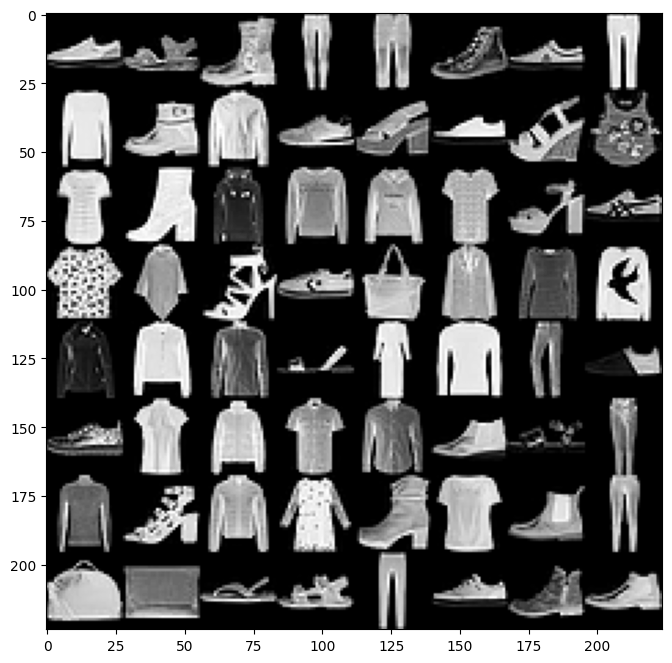

In [5]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

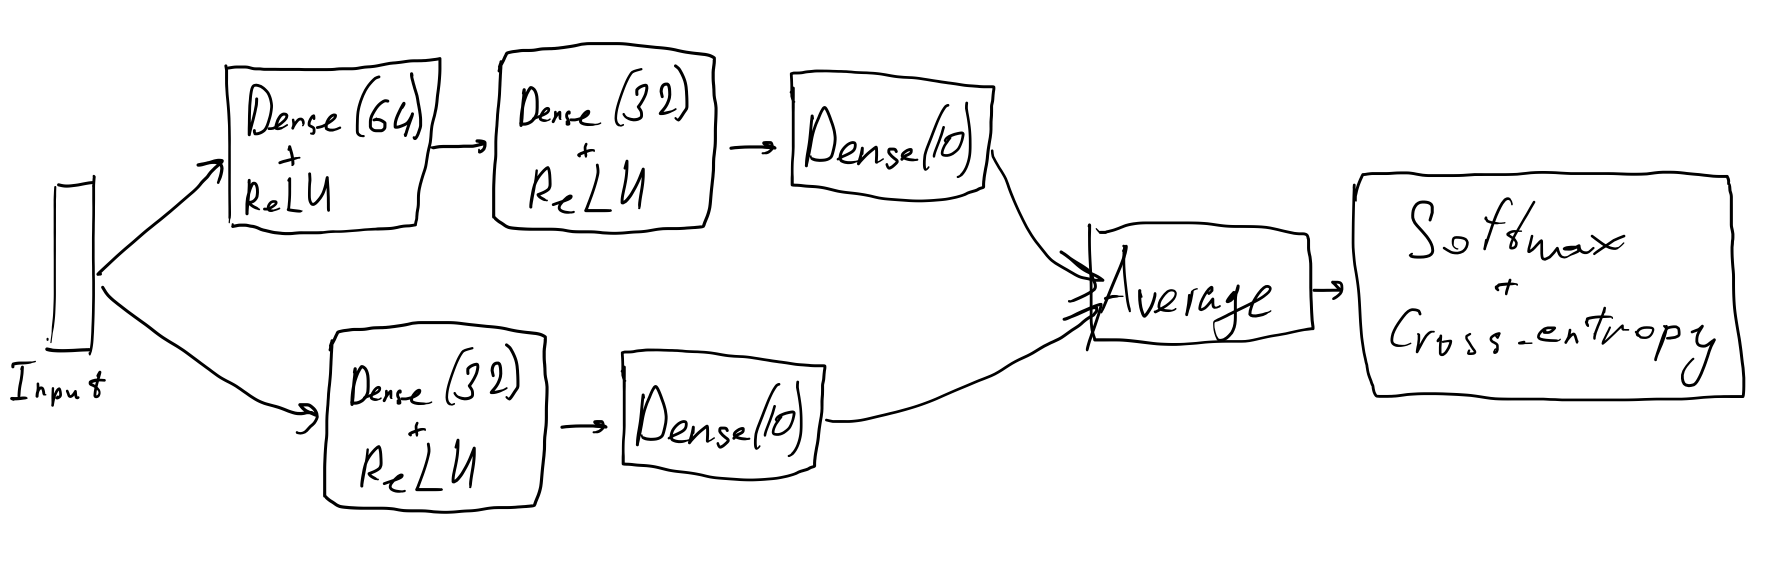

Ensemble Model Predictions:
['Pullover' 'T-shirt/top' 'Dress' 'Sneaker' 'Sandal' 'Coat' 'Trouser'
 'Dress' 'Coat' 'Ankle boot' 'Shirt' 'Trouser' 'Sandal' 'Pullover'
 'Trouser' 'Ankle boot' 'Sandal' 'T-shirt/top' 'Trouser' 'Shirt' 'Dress'
 'Trouser' 'Trouser' 'Sneaker' 'T-shirt/top' 'T-shirt/top' 'Sneaker'
 'Dress' 'Bag' 'Coat' 'T-shirt/top' 'Bag' 'Shirt' 'Dress' 'Pullover'
 'Ankle boot' 'Pullover' 'Ankle boot' 'Shirt' 'T-shirt/top' 'Sandal'
 'Trouser' 'Coat' 'Ankle boot' 'Trouser' 'Ankle boot' 'Bag' 'T-shirt/top'
 'Pullover' 'Sneaker' 'Pullover' 'T-shirt/top' 'Sandal' 'Coat' 'Pullover'
 'Ankle boot' 'Bag' 'Pullover' 'Trouser' 'Pullover' 'Sandal' 'Sandal'
 'Coat' 'Sandal']


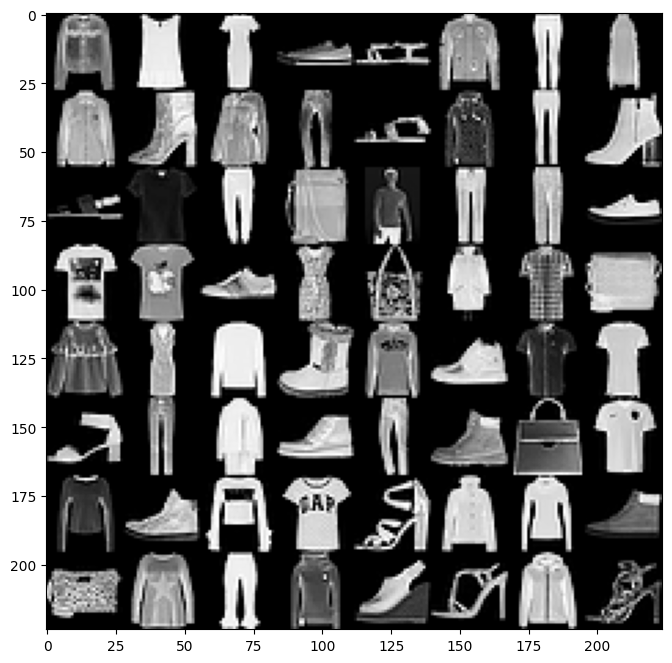

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import numpy as np
import matplotlib.pyplot as plt

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

# ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        # Average the predictions
        averaged_output = (output1 + output2) / 2
        return averaged_output

learning_rate = 0.001
epochs = 10

# FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

model1 = Model1()
model2 = Model2()
ensemble_model = EnsembleModel(model1, model2)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = ensemble_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# batch of test data
testset = FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)
dataiter = iter(testloader)
images, labels = next(dataiter)  # Corrected this line

# predictions with the ensemble model
ensemble_outputs = ensemble_model(images)
_, ensemble_predicted = torch.max(ensemble_outputs, 1)

print("Ensemble Model Predictions:")
print(label_names[ensemble_predicted.numpy()])

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224), cmap='gray')
plt.show()